In [1]:
import numpy as np
from datetime import date

from pulse2percept import electrode2currentmap as e2cm
from pulse2percept import effectivecurrent2brightness as ec2b
from pulse2percept.utils import TimeSeries

import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
def get_brightest_frame(resp):
    # Find brightest element
    idx_px = resp.data.argmax()
    
    # Find frame where brightest pixel is: unravel maps flat index onto
    # high-dimensional indices (x,y,z). What we want is index z (the frame index).
    idx_frame = np.unravel_index(idx_px, resp.shape)[-1]
    
    return TimeSeries(resp.tsample, resp.data[..., idx_frame])

In [2]:
def setup_model(exp_params):
    model = dict()
    
    # set up temporal model
    model['tm'] = ec2b.TemporalModel(model=exp_params['model'],
                                     tsample=exp_params['tsample'])

    # Electrode locations for patient TB (in microns), from MATLAB script
    x_elec_loc = np.array([-6825.092215, -6332.563035, -5840.033855, -5347.504675,
                           -6194.683612, -5702.154432, -5209.625252, -4717.096072,
                           -5564.275010, -5071.745829, -4579.216649, -4086.687469,
                           -4933.866407, -4441.337226, -3948.808046, -3456.278866])
    y_elec_loc = np.array([-655.666769, -25.258166, 605.150437, 1235.559040,
                           -1148.195949, -517.787346, 112.621257, 743.029860,
                           -1640.725129, -1010.316526, -379.907924, 250.500679,
                           -2133.254310, -1502.845707, -872.437104, -242.028501])

    # MATLAB had the OD at (0,0), we have it at (15,2) deg
    x_elec_loc += e2cm.deg2micron(15)
    y_elec_loc += e2cm.deg2micron(2)
    
    # Radii (almost) alternating to create checkerboard pattern
    r_arr = np.array([260, 520, 260, 520]) / 2.0
    r_arr = np.concatenate((r_arr, r_arr[::-1], r_arr, r_arr[::-1]), axis=0)
    
    # Set electrode height to something realistic
    h_arr = np.ones(16)*100

    model['implant'] = e2cm.ElectrodeArray(r_arr.tolist(), x_elec_loc.tolist(),
                                           y_elec_loc.tolist(), h_arr.tolist())

    # find x,y limits from electrode location
    round_to_nearest = 200.0  # microns
    x_min = np.floor((x_elec_loc.min() - 500.0) / round_to_nearest) * round_to_nearest
    x_max = np.ceil((x_elec_loc.max() + 500.0) / round_to_nearest) * round_to_nearest
    y_min = np.floor((y_elec_loc.min() - 500.0) / round_to_nearest) * round_to_nearest
    y_max = np.ceil((y_elec_loc.max() + 500.0) / round_to_nearest) * round_to_nearest

    r_file = '../retina_argusI_s%d_l%.0f_%dx%d.npz' % (exp_params['r_sampling'],
                                                       exp_params['axon_lambda'],
                                                       x_max - x_min, y_max - y_min)
    model['retina'] = e2cm.Retina(axon_map=r_file, sampling=exp_params['r_sampling'],
                                  xlo=x_min, xhi=x_max, ylo=y_min, yhi=y_max,
                                  axon_lambda=exp_params['axon_lambda'])
    
    # We derive the effective current stimulation (ecs; passed through the effect of
    # the retinal layout, axons, etc.) in addition to the current (cs):
    ecs, cs = model['retina'].electrode_ecs(model['implant'],
                                            integrationtype=exp_params['integrationtype'],
                                            normalizationtype=exp_params['normalizationtype'])
    model['ecs'], model['cs'] = ecs, cs
    
    return model

In [3]:
def run_condition(idx_cond, exp_params, model):
    """Run a single condition of the Horsager experiment"""
    
    idx_E1 = exp_params['idx_E1']
    idx_E2 = exp_params['idx_E2']
    
    # Set up currents and delays
    if idx_cond == 1:
        # Condition 1: E1 fixed, all others zero
        amp_E1 = np.linspace(0.8, 1.2, 3) * exp_params['amp_ref']
        amp_E2 = np.zeros_like(amp_E1)
        delays = [0]
    elif idx_cond == 2:
         # Condition 2: E2 fixed, all others zero
        amp_E2 = np.linspace(0.8, 1.2, 3) * exp_params['amp_ref']
        amp_E1 = np.zeros_like(amp_E2)
        delays = [0]
    elif idx_cond == 3:
        # Condition 3: E1 fixed, E2 varies
        # Make current sum to 75% - 125% of amp_ref
        amp_E2 = np.linspace(0.5, 0.9, 3) * exp_params['amp_ref']
        amp_E1 = np.ones_like(amp_E2) * 0.35 * exp_params['amp_ref']
        delays = [0.075/1000, 0.375/1000, 1.8/1000, 9/1000]
    elif idx_cond == 4:
        # Condition 4: E2 fixed, E1 varies
        amp_E1 = np.linspace(0.5, 0.9, 3) * exp_params['amp_ref']
        amp_E2 = np.ones_like(amp_E1) * 0.35 * exp_params['amp_ref']
        delays = [0.075/1000, 0.375/1000, 1.8/1000, 9/1000]
    elif idx_cond == 5:
        # Condition 5: Both E1 and E2 vary
        amp_E1 = np.linspace(0.5, 0.9, 3) * exp_params['amp_ref']
        amp_E2 = np.linspace(0.5, 0.9, 3) * exp_params['amp_ref']
        delays = [0.075/1000, 0.375/1000, 1.8/1000, 9/1000]
    else:
        raise ValueError('Unknown idx_cond ' + str(idx_cond))
        
    data = dict()
    data['frames'] = []
    data['amp_E1'] = []
    data['amp_E2'] = []
    data['delay'] = []
    print ("- Condition %d" % idx_cond)
    for dd in delays:
        print("  - delay %.3f" % (dd*1000))
        
        for a1, a2 in zip(amp_E1, amp_E2):
            # generate list of pulse trains
            pt_list = []
            for j in range(16):
                if j == idx_E1:
                    pt_list.append(get_pulse_train(a1, tsample=exp_params['tsample']))
                elif j == idx_E2:
                    pt_list.append(get_pulse_train(a2, delay_dur=dd,
                                                   tsample=exp_params['tsample']))
                else:
                    # all others zero
                    pt_list.append(get_pulse_train(0, tsample=exp_params['tsample']))
            
            # Calculate response
            if exp_params['use_ecs']:
                current_spread = model['ecs']
            else:
                current_spread = model['cs']
            resp = ec2b.pulse2percept(model['tm'], current_spread, model['retina'],
                                      pt_list, 30, dojit=True, n_jobs=4)

            # Find brightest frame
            brightest = get_brightest_frame(resp)

            # Save data
            data['frames'].append(brightest)
            data['amp_E1'].append(a1)
            data['amp_E2'].append(a2)
            data['delay'].append(dd)
            
    return data

In [4]:
def run_experiment(exp_params, model):
    exp_params['date'] = date.today().strftime("%Y-%m-%d")
    print('Experiment: %s (%s, %s) %s %s' % (exp_params['name'],
                                             exp_params['name_E1'],
                                             exp_params['name_E2'],
                                             exp_params['date'],
                                             date.today().strftim("%H-%i")))
    
    datapath = exp_params['save_dir']
    if not datapath.endswith('/'):
        datapath += '/'
    prefix = exp_params['name']
    electrodes = 'E%d_E%d' % (exp_params['idx_E1'], exp_params['idx_E2'])
    suffix = '%s_%.1fX.npz' % (exp_params['date'], exp_params['fac_thresh'])

    # Check if we ran this experiment already
    import os
    for file in os.listdir(datapath):
        if file.startswith(prefix + '_' + electrodes):
            print('File that starts with %s%s_%s already exists, skip' % (datapath,
                                                                           prefix,
                                                                           electrodes))
            return

    # Generate filename and make sure we can write to it
    # Do this now rather than after hours of number crunching...
    filename = '%s%s_%s_%s' % (datapath, prefix, electrodes, suffix)
    np.savez(filename, data=np.zeros(10))
    print('- File: %s' % filename)
    exp_params['filename'] = filename

    # Run all 5 conditions
    data = dict()
    for idx_cond in range(5):
        name_cond = 'cond' + str(idx_cond + 1)
        data[name_cond] = run_condition(idx_cond + 1, exp_params, model)

    # Save results to .npz
    np.savez(filename, data=data, exp_params=exp_params, model=model)
    print('- Results saved to %s' % filename)

In [5]:
# We could use ec2b.Psycho2Pulsetrain, but we'd like to have the stimulus first, 
# followed by the inter-pulse gap. ec2b.Psycho2Pulsetrain has the inter-pulse
# gap first...
def get_pulse_train(ampl, delay_dur=0, tsample=1e-5):
    freq = 50
    pulse_dur = 0.45/1000
    stim_dur = 0.5

    # envelope size (single pulse + gap) given by `freq`
    envelope_size = int(np.round((1/freq) / tsample))

    # delay given by `delay_dur`
    delay_size = int(np.round(delay_dur / tsample))
    delay = np.zeros(delay_size)

    # single pulse given by `pulse_dur`
    pulse = ampl * e2cm.get_pulse(pulse_dur, tsample, pulse_dur, 'cathodicfirst')
    pulse_size = pulse.size

    # then gap is used to fill up what's left
    gap_size = envelope_size - delay_size - pulse_size
    gap = np.zeros(gap_size)

    pulse_train = []
    for j in range(int(np.round(stim_dur * freq))):
        pulse_train = np.concatenate((pulse_train, delay, pulse, gap), axis=0)
    
    return TimeSeries(tsample, pulse_train)

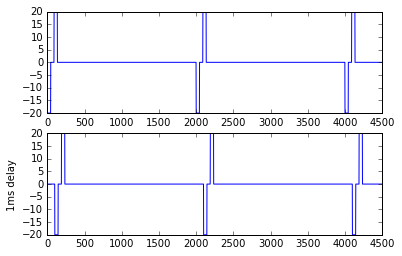

In [6]:
plt.subplot(211)
plt.plot(get_pulse_train(20, 0).data[0:4500])

plt.subplot(212)
plt.plot(get_pulse_train(20, 1/1000).data[0:4500])
plt.ylabel('1ms delay')

In [ ]:
exp_params = dict()

# give the experiment a name
exp_params['name'] = 'nanduri'

# where to save the data (relative path)
exp_params['save_dir'] = 'data/lambda1/'

# sampling step in seconds
exp_params['tsample'] = 0.01/1000

# some factor x threshold
exp_params['fac_thresh'] = 1.5

# threshold current in micro amps
exp_params['amp_thresh'] = 30

# reference current at `fac_thresh` times threshold
exp_params['amp_ref'] = exp_params['fac_thresh'] * exp_params['amp_thresh']

# model flavor
exp_params['model'] = 'Nanduri'

# whether to use effective current map (True) or current map (False)
exp_params['use_ecs'] = True

exp_params['axon_lambda'] = 1
exp_params['r_sampling'] = 100
exp_params['integrationtype'] = 'dotproduct'
exp_params['normalizationtype'] = 'maxcs'

model = setup_model(exp_params)

In [ ]:
# 15 different electrode pairs
idx_E1  = [   2,   0,  10,   2,  10,   9,  12,   5,   4,   9,   0,   0,  14]
name_E1 = ['C1','A1','C3','C1','C3','B3','A4','B2','A2','B3','A1','A1','C4']
idx_E2  = [   3,   4,   6,   1,   5,   5,  13,  13,   6,   1,   2,  12,   2]
name_E2 = ['D1','A2','C2','B1','B2','B2','B4','B4','C2','B1','C1','A4','C1']

for idx1, name1, idx2, name2 in zip(idx_E1, name_E1, idx_E2, name_E2):
    exp_params['idx_E1'] = idx1
    exp_params['idx_E2'] = idx2
    exp_params['name_E1'] = name1
    exp_params['name_E2'] = name2
    
    t_exe = %timeit -oq -n1 -r1 run_experiment(exp_params, model)
    print('- Experiment took %.1f s' % t_exe.best)

Experiment: nanduri (C1, D1) 2016-11-03
File that starts with data/lambda1/nanduri_E2_E3 already exists, skip
- Experiment took 0.0 s
Experiment: nanduri (A1, A2) 2016-11-03
File that starts with data/lambda1/nanduri_E0_E4 already exists, skip
- Experiment took 0.0 s
Experiment: nanduri (C3, C2) 2016-11-03
File that starts with data/lambda1/nanduri_E10_E6 already exists, skip
- Experiment took 0.0 s
Experiment: nanduri (C1, B1) 2016-11-03
File that starts with data/lambda1/nanduri_E2_E1 already exists, skip
- Experiment took 0.0 s
Experiment: nanduri (C3, B2) 2016-11-03
File that starts with data/lambda1/nanduri_E10_E5 already exists, skip
- Experiment took 0.0 s
Experiment: nanduri (C2, B2) 2016-11-03
File that starts with data/lambda1/nanduri_E6_E5 already exists, skip
- Experiment took 0.0 s
Experiment: nanduri (B3, B2) 2016-11-03
File that starts with data/lambda1/nanduri_E9_E5 already exists, skip
- Experiment took 0.0 s
Experiment: nanduri (A4, B4) 2016-11-03
File that starts wit